# Model Evaluation and Interpretation

In [1]:
from fastai.text import *
from fastai.lm_rnn import *
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import html

TWEETSLM_PATH=Path('./LM_tweets')
CLAS_PATH=Path('./tweets_class')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

# Helper Functions

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Results

F1(macro) =  0.7308588062526968
Accuracy  =  0.75


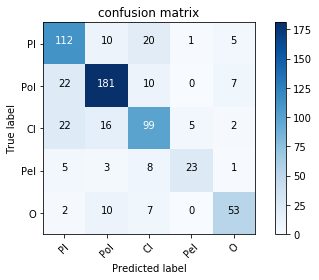

In [5]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
tst_lbls -= tst_lbls.min()
c=int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_sent_sampled = tst_sent[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()

# EDA

In [6]:
tokens = [" ".join([itos[id] for id in tweet]) for tweet in tst_sent_sampled]
df = pd.DataFrame({'tokens':tokens, 
                   'actual': tst_lbls_sampled , 
                   'prediction': predictions})


df['actual'] = df['actual'].replace([0, 1, 2, 3, 4], ['PI', 'PoI', 'CI', 'PeI', 'O'])
df['prediction'] = df['prediction'].replace([0, 1, 2, 3, 4], ['PI', 'PoI', 'CI', 'PeI', 'O'])


In [7]:
wrong_preds = df.loc[df['actual']!=df['prediction']].values

for tweet in wrong_preds:
    print(tweet[0])
    print(f'pred: {tweet[2]}, actual: {tweet[1]}')


 xbos rt _unk_ : al opinar tengan en cuenta que talegón era la joven _unk_ del t_up psoe . hyp_link t_up tweet t_up citado t_up por el t_up retweeteado : _unk_ talegón , sobre venezuela : " en españa también hay _unk_ _unk_ durante las campañas , pero no son portada " . _unk_ .
pred: PI, actual: CI

 xbos rt @marisaparrilla : los socialistas , los primeros en dar ejemplo hash_tag # compromisoético hash_tag # _unk_ hash_tag # nosunepedro hyp_link t_up tweet t_up citado t_up por el t_up retweeteado : @sanchezcastejon @ t_up psoe hash_tag # compromisoético que necesitamos en todos los políticos . los socialistas somos los primeros en dar ejemplo .
pred: PI, actual: PoI

 xbos .@agarzon , candidato que no se _unk_ a la sociedad del _unk_ a la que _unk_ _unk_ los ciudadanos . hyp_link t_up tweet t_up citado : " pedimos el máximo apoyo para las _unk_ de @unidadpopular _ _ que _unk_ @agarzon ... en enero empieza todo " hyp_link
pred: PoI, actual: CI

 xbos rt _unk_ : t_up reconocer y _unk_ a

In [8]:
right_preds = df.loc[df['actual']==df['prediction']]['tokens'].values
for tweet in right_preds:
    print(tweet)


 xbos rt @albert_rivera : el pp ' se queja ' de que la televisión pública _unk_ también el inicio de campaña de @ciudadanoscs . y no es broma . hyp_link t_up tweet t_up citado t_up por el t_up retweeteado : el hash_tag # pp se _unk_ de la cobertura de t_up _unk_ en campaña por " _unk_ " a hash_tag # ciudadanos y hash_tag # podemos . la t_up jec lo ha _unk_ hyp_link

 xbos rt _unk_ : puede parecer un tweet falso hecho a _unk_ como los de _unk_ ramos pero no : es real … ¡ que no salga este payaso tío ! hyp_link t_up tweet t_up citado t_up por el t_up retweeteado : nos vota gente muy diferente , hash_tag # tambiénloshipsters . confía en el @ppopular , hash_tag # sinprejuicios . por ti . por todos hyp_link

 xbos rt _unk_ : que tk_rep 4 * en la _unk_ se merece . para los fascistas los miles y miles de _unk_ en _unk_ son _unk_ de 3ª o 4ª hyp_link t_up tweet t_up citado t_up por el t_up retweeteado : maroto ( pp ) , _unk_ que los sirios no merecen minutos de silencio . t_up basura y t_up mi

# EDA continued

In [9]:
PI_df = df.loc[df['actual']=='PI']
PI_df['prediction'].value_counts()

PI     112
CI      20
PoI     10
O        5
PeI      1
Name: prediction, dtype: int64

In [10]:
for tok in PI_df.loc[PI_df['prediction']=='CI']['tokens'].values:
    print(tok)


 xbos rt _unk_ : el _unk_ de _unk_ del t_up psoe , mañana en sus _unk_ ( via _unk_ ) hyp_link t_up tweet t_up citado t_up por el t_up retweeteado : hash_tag # _unk_ mañana en t_up _unk_ hyp_link

 xbos consejos de _unk_ en la hash_tag # jornadadereflexion hyp_link t_up tweet t_up citado : quien vote _unk_ vota pp 2.0 . luego no _unk_ los _unk_ . he dicho . hash_tag # _unk_

 xbos _unk_ nada , sigue con tu odio a podemos , y tu amor por gonzález , aznar y rivera . te debe ir bien en la vida cuando tanto los quieres

 xbos rt _unk_ : _unk_ sin _unk_ para _unk_ el hash_tag # t_up 20d a @albert_rivera a la _unk_ el cambio sensato . vota c 's . t_up _unk_ hyp_link

 xbos rt @yo_soy_asin : mi consejo para los que quieran votar a hash_tag # ciudadanos tk_rep 4 . _unk_ el programa electoral tk_rep 4 . gracias hash_tag # demosespaña hyp_link

 xbos ¡ ¡ _unk_ ! ! hyp_link t_up tweet t_up citado : sánchez acaba de llamar comunista a pablo iglesias en directo . es que no _unk_ crédito .

 xbos rt

# Vocab 

In [11]:
print(len(itos))
itos

3569


['_unk_',
 '_pad_',
 '\n',
 'xbos',
 ':',
 't_up',
 'hyp_link',
 'de',
 '#',
 'hash_tag',
 'rt',
 'el',
 'que',
 '.',
 'la',
 'a',
 ',',
 'y',
 'en',
 '"',
 'no',
 'los',
 'pp',
 '…',
 'es',
 'rajoy',
 'por',
 'del',
 'con',
 'psoe',
 'un',
 'ciudadanos',
 'se',
 'para',
 'las',
 'al',
 'int_string',
 '!',
 '?',
 'rivera',
 'lo',
 '_',
 '...',
 'tweet',
 'citado',
 '@',
 'ha',
 'más',
 'slang_string',
 'una',
 '¿',
 '20d',
 'su',
 'si',
 'españa',
 'podemos',
 'como',
 '@ciudadanoscs',
 '-',
 '@pablo_iglesias',
 '@sanchezcastejon',
 '@ahorapodemos',
 'me',
 'iglesias',
 '@marianorajoy',
 'pablo',
 '@albert_rivera',
 'retweeteado',
 '@ppopular',
 "'",
 'pero',
 'le',
 '¡',
 'gobierno',
 '%',
 '(',
 'te',
 'hay',
 'albert',
 ')',
 'qué',
 'o',
 'ya',
 'c',
 'sánchez',
 'presidente',
 '4',
 'son',
 "'s",
 'debate',
 'tk_rep',
 'nos',
 'partido',
 'tiene',
 'vía',
 'este',
 'ahora',
 'sus',
 'contra',
 'ni',
 'votar',
 '7deldebatedecisivo',
 'han',
 'está',
 'eso',
 'campaña',
 'todos',
 '